# Connected image filtering with component trees

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

This tutorial will show you how to apply a connected filter on an image using component trees. 

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.transform import resize
import higra as hg

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())


We will process a grayscale image with bright and dark features

Image size: (250, 250)


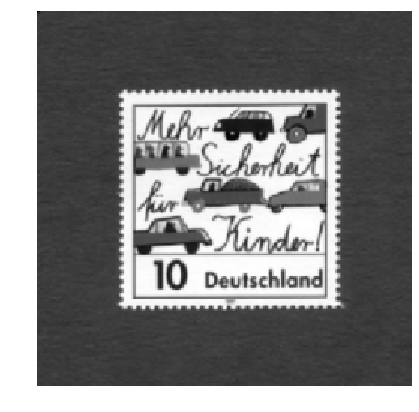

In [3]:
image = imageio.imread(locate_resource("stample4.png"))
image = image[:250, :250]
size = image.shape
print("Image size:", size)
imshow(image, cmap='gray');

## Area filtering with a max tree

The max tree is a component hierarchy that represents the maxima of the image. Thus, the small bright regions can be removed by filtering the small nodes of the max tree.

First, contruction of the hierarchy:

In [4]:
graph = hg.get_4_adjacency_graph(size)
tree, altitudes = hg.component_tree_max_tree(graph, image)

Then, computation of the attribute used to guide the filtering process

In [5]:
area = hg.attribute_area(tree)

Finally, we reconstruct the image data from the tree ignoring nodes having an area smaller than 100 pixels.

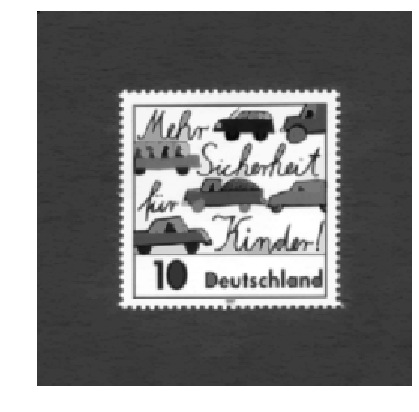

In [6]:
result = hg.reconstruct_leaf_data(tree, altitudes, area < 100)
imshow(result, cmap='gray');

## Interractive example with various trees and attributes

The three possible trees are:

- the Min Tree (tree of minima), 
- the Max Tree (tree of maxima), and 
- the Tree of Shapes (tree of minima and maxima).

In [7]:
trees = {
    "Min Tree" : hg.component_tree_min_tree(graph, image),
    "Max Tree" : hg.component_tree_max_tree(graph, image),
    "Tree of Shapes": hg.component_tree_tree_of_shapes_image2d(image)
}

We consider three possible attributes:

- area: number of pixels in a node
- height: difference between the node altitudes and its deepest descendant (measure of contrast)
- compactness: area of a node divided by its squared perimeter 

In [8]:
attributes = {
    "area": lambda tree, altitudes: hg.attribute_area(tree),
    "height": lambda tree, altitudes: hg.attribute_height(tree, altitudes) * 4,
    "compactness": lambda tree, altitudes: hg.attribute_compactness(tree) * 1000,
}

While the area and the height are increasing attributes (the attribute value of a node is always smaller or equal than the attribute value of its parent), the compactness is not. Several strategies exist to deal with this situation, see eg:

    Salembier, P., Oliveras, A., & Garrido, L. (1998). Antiextensive connected operators for image and sequence processing. IEEE Transactions on Image Processing, 7(4), 555-570.

In [9]:
filtering_rule = {
    "direct": lambda tree, altitudes, deleted_nodes: (altitudes, deleted_nodes),
    "min": lambda tree, altitudes, deleted_nodes: (altitudes, hg.propagate_sequential(tree, deleted_nodes, np.logical_not(deleted_nodes))),
    "max": lambda tree, altitudes, deleted_nodes: (altitudes, hg.accumulate_and_min_sequential(tree, deleted_nodes, np.ones((tree.num_leaves(),)), hg.Accumulators.min)),
}

In [10]:
from ipywidgets import interact, FloatSlider

def filtering(sTree, sAttr, sRule, sThreshold):  
    
    tree, altitudes = trees[sTree]
    attribute = attributes[sAttr](tree, altitudes)
    
    deleted_nodes = attribute < sThreshold
    deleted_nodes = deleted_nodes.astype(np.int32)
    
    altitudes, deleted_nodes = filtering_rule[sRule](tree, altitudes, deleted_nodes)
    
    result = hg.reconstruct_leaf_data(tree, altitudes, deleted_nodes.astype(np.bool))
    
    imshow(result, cmap='gray')

interact(filtering, 
        sTree=['Min Tree', 'Max Tree', 'Tree of Shapes'], 
        sAttr=['area', 'height', 'compactness'],
        sRule=['direct', 'min', 'max', 'subtractive'],
        sThreshold=FloatSlider(min=0, max=1000, step=1, continuous_update=False));

interactive(children=(Dropdown(description='sTree', options=('Min Tree', 'Max Tree', 'Tree of Shapes'), value=…